# Factor Analysis

Factor analysis is a method for automatically finding latent variables in a data set. It assumes that observed variables are actually a linear combination of a number of latent factors. Often, we are aiming to find a smaller number of factors that explain trends in our data.

This is how factor analysis differs from principal componant analysis. In PCA, the components are not interpretable, however, in factor analysis, we can see which observed variables are highly correlated with which factors and group observed variables according to which factors they are correlated with by looking at the loading. We can also see which factors are most important by their eiganvalues. Another technical difference between PCA and factor analysis is that in PCA, all the components are orthogonal but in factor analysis this does not need to be the case.

## Load Data

In [1]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt

In [2]:
wellness_df = pd.read_csv('./raw_data/wellness.csv')
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,23:00:00,07:00:00,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,23:00:00,07:00:00,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,22:30:00,06:30:00,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,00:30:00,07:00:00,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,23:45:00,07:00:00,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100%


In [3]:
wellness_df.shape

(5011, 19)

To start with, we have 5011 wellness observations.

## Cleaning Data

### Fatigue

In [4]:
wellness_df['Fatigue'].value_counts()

4    2003
3    1721
2     642
5     301
1     187
6     150
7       7
Name: Fatigue, dtype: int64

Based on the codebook, 1 is most tired and 7 is most fresh. The scales are:
1 -> Exhausted
4 -> Average
7 -> Fresher than usual

Thus, the values above make sense with average being most common and 1 less than average being second most common. I think we should be good leaving the values as is here.

### Soreness, Desire and Irritability

All of these columns are on the same scale as fatigue so we just need to make sure there are no missing values and we can continue using the raw values as with Fatigue.

In [5]:
wellness_df['Soreness'].value_counts()

4    1843
3    1831
2     737
5     280
1     176
6     128
7      16
Name: Soreness, dtype: int64

In [6]:
wellness_df['Desire'].value_counts()

4    3023
3     820
5     428
2     300
6     228
1     159
7      53
Name: Desire, dtype: int64

In [7]:
wellness_df['Irritability'].value_counts()

4    3597
3     650
5     347
6     180
2     135
7      61
1      41
Name: Irritability, dtype: int64

No missing values so all these columns can be used as is.

### BedTime, WakeTime, and SleepHours

If we have SleepHours, it seems like we do not need BedTime and WakeTime as wellness would be affected by the amount of sleep and not the particular times players went to bed. Furthermore, most players go to bed and wake up at the same time. So, I will removed the `BedTime` and `Waketime` columns from the dataframe.

In [8]:
wellness_df = wellness_df.drop(columns=['BedTime', 'WakeTime'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100%


### Sleep Quality

In [9]:
wellness_df['SleepQuality'].value_counts()


4    2505
3    1037
5     508
2     386
6     242
1     193
7     140
Name: SleepQuality, dtype: int64

No missing values so we can leave this column as is. One interesting thought is how does this correlate with sleep duration?

#### Correlation With Sleep

In [10]:
wellness_df['SleepQuality'].corr(wellness_df['SleepHours'])

0.28179835513040297

It turns out sleep quality and the duration of sleep are not very correlated so we can keep them both in the data set.

### Monitoring Score

This is an aggregation of the 5 scale values. We could either use this or the 5 scales on their own but it would not be appropriate to use both. We are trying to see if our data can be represented as latent factors so we should ignore this summary column and see if the columns that it is made from are actually all related.

In [11]:
wellness_df = wellness_df.drop(columns=['MonitoringScore'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,No,No,No,Okay,Yes,Yes,1.022,100%


### Pain

In [12]:
wellness_df['Pain'].value_counts()

No     4423
Yes     588
Name: Pain, dtype: int64

No missing values but we need to code this `Yes/No` column to take the values `1/0`

In [13]:
wellness_df['Pain'] = wellness_df['Pain'].map(dict(Yes=1, No=0))
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,1,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,0,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,0,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,0,No,No,Okay,Yes,Yes,1.022,100%


### Illness

This should be trated the same as `Pain` assuming there are no missing values 

In [14]:
wellness_df['Illness'].value_counts()

No              4456
Slightly Off     421
Yes              134
Name: Illness, dtype: int64

It turns out there is a medium category of `Slightly Off` between `Yes` and `No`. So, I will code this column as a ordered categorical variable. I don't want to encode the difference between fully sick and being slightly off as the same as being slightly off and not sick. It seems the distance from not sick to slightly off is less than between slightly off and sick. So, instead of encoding sick as `2`, I will bump it up to `3`.

In [15]:
wellness_df['Illness'] = wellness_df['Illness'].map({'Yes': 3, 'Slightly Off': 1, 'No': 0})
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,No,Okay,Yes,Yes,1.022,100%


### Menstruation

In [16]:
wellness_df['Menstruation'].value_counts()

No     4285
Yes     710
Name: Menstruation, dtype: int64

Update: it seems like `value_counts` does not show values that are NaN so I will need to check for that separatly

In [17]:
wellness_df[~ wellness_df['Menstruation'].isnull()].shape

(4995, 16)

17 observations is a small amount compared to 5011 overall so I will just remove the obervations that are missing Menstruation data.

In [18]:
wellness_df = wellness_df[~ wellness_df['Menstruation'].isnull()]

wellness_df.shape

(4995, 16)

This is a simple `Yes/No` column so we can encode it with integers 1 and 0.

In [19]:
wellness_df['Menstruation'] = wellness_df['Menstruation'].map(dict(Yes=1, No=0))
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,Okay,Yes,Yes,1.022,100%


### Nutrition

In [20]:
wellness_df['Nutrition'].value_counts()


Excellent    2706
Okay         1394
Poor           63
Name: Nutrition, dtype: int64

In [21]:
wellness_df[wellness_df['Nutrition'].isnull()].shape


(832, 16)

I will encode this as a ordered categorical variable with equal space between categories

In [22]:
wellness_df['Nutrition'] = wellness_df['Nutrition'].map({'Excellent': 3, 'Okay': 2, 'Poor': 1})
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,3.0,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,3.0,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,2.0,Yes,Yes,1.022,100%


### NutritionAdjustment

In [23]:
wellness_df['NutritionAdjustment'].value_counts()

Yes             3718
No               438
I Don't Know      99
Name: NutritionAdjustment, dtype: int64

In [24]:
wellness_df[wellness_df['NutritionAdjustment'].isnull()].shape

(740, 16)

We could map all missing values for nutrition adjustment to the "I don't know" value but then we would have more "I don't knows" than "No". How do we encode this?

Since there are so many missing values, I will remove the nutrition columns for now

In [25]:
wellness_df = wellness_df.drop(columns=['Nutrition', 'NutritionAdjustment'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,Yes,1.022,100%


### USG

`USGMeasirement` is just a flag that tells us whether there is a value for USG on that row so it does not prodive us any useful information we could not get from just looking at the `USG` column. So, I will drop it.

In [26]:
wellness_df = wellness_df.drop(columns=['USGMeasurement'])


In [27]:
wellness_df[wellness_df['USG'].isnull()].shape


(4370, 13)

There are so many missing measuresments for `USG` that I don't think we could do anything over than dropping it.

In [28]:
wellness_df = wellness_df.drop(columns=['USG'])


### TrainingReadiness

In [29]:
wellness_df['TrainingReadiness'].value_counts()

100%    1434
0%      1004
90%      641
95%      590
85%      293
80%      226
75%      201
70%      152
65%      111
50%       72
60%       70
55%       52
35%       26
45%       23
25%       17
30%       17
40%       16
15%       14
20%       14
5%        11
10%       11
Name: TrainingReadiness, dtype: int64

In [30]:
wellness_df[wellness_df['TrainingReadiness'].isnull()].shape

(0, 12)

Training readiness has no missing values and is expressed as percentages. I can map this to integers.

In [31]:
wellness_df['TrainingReadiness'] = wellness_df.apply(lambda row: int(row['TrainingReadiness'][0:-1]), axis=1)
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,0
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,0
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,100
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,95
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,100


In [32]:
wellness_df.shape

(4995, 12)

After all my cleaning, I am left with 4995 observations and 11 observed variables for factor analysis (date and player id are not useful in this case.

## Factor Analysis

In [33]:
wellness_df.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,0
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,0
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,100
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,95
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,100


### Averaging Over Different Dates

We cannot perform factor analysis using data gathered at different dates. So for each player, we need to average all their values. In doing so, we can interpret most columns as "Average X", i.e. "Average Sleep Hours". However, we cannot do this for the binary categorical columns. We could instead interpret these as probabilities, i.e., probability of being Ill.

#### Question:

Why is this? Is it because the observations for a given individual will not be independent over many different days?

In [34]:
wellness_df = wellness_df.drop(columns=['Date'])
wellness_df = wellness_df.groupby('PlayerID',as_index = False).mean()
wellness_df.head()


,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,TrainingReadiness
0,1,2.671924,3.302839,2.479495,3.936909,8.715300,3.611987,0.025237,0.151420,0.157729,21.435331
1,2,3.779762,3.276786,4.113095,4.151786,9.053571,4.122024,0.205357,0.044643,0.187500,11.651786
2,3,3.350725,3.176812,3.455072,3.979710,7.879710,3.913043,0.026087,0.000000,0.118841,98.115942
3,4,3.305195,3.542208,3.935065,3.668831,8.266234,2.954545,0.006494,0.016234,0.146104,66.996753
4,5,3.803089,3.814672,4.324324,3.965251,7.925676,3.841699,0.316602,0.254826,0.111969,65.637066


Now that we have averaged over all the days for each player, we can drop the player id column.

In [35]:
wellness_df = wellness_df.drop(columns=['PlayerID'])


### Adequacy Tests

Before we perform any partiular tests for suitability, we should make sure there are not any columns that are correlated in our dataset.

In [36]:
wellness_df.corr()

,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,TrainingReadiness
Fatigue,1.000000,0.864415,0.839981,0.872072,0.197166,0.793575,-0.149257,-0.168557,-0.350946,0.057665
Soreness,0.864415,1.000000,0.661108,0.805039,0.057078,0.681841,-0.168149,-0.179042,-0.177611,-0.101565
Desire,0.839981,0.661108,1.000000,0.580191,0.238104,0.592546,0.020143,-0.176135,-0.281295,0.229256
Irritability,0.872072,0.805039,0.580191,1.000000,0.198796,0.807746,-0.055961,0.045648,-0.275293,-0.082904
SleepHours,0.197166,0.057078,0.238104,0.198796,1.000000,0.401260,-0.297852,-0.357908,-0.025995,0.007867
SleepQuality,0.793575,0.681841,0.592546,0.807746,0.401260,1.000000,-0.302088,-0.277461,-0.335666,0.035654
Pain,-0.149257,-0.168149,0.020143,-0.055961,-0.297852,-0.302088,1.000000,0.739189,0.220786,-0.174203
Illness,-0.168557,-0.179042,-0.176135,0.045648,-0.357908,-0.277461,0.739189,1.000000,0.018446,-0.074957
Menstruation,-0.350946,-0.177611,-0.281295,-0.275293,-0.025995,-0.335666,0.220786,0.018446,1.000000,-0.172369
TrainingReadiness,0.057665,-0.101565,0.229256,-0.082904,0.007867,0.035654,-0.174203,-0.074957,-0.172369,1.000000


#### A note on correlation

Remember that we are just trying to make sure we do not have perfect multicollinearity here. Even if observations have high correlation with eachother, we are just trying to make sure there are no ones in the correlation matrix.

In [37]:
r, p = pointbiserialr(wellness_df['Pain'], wellness_df['Irritability'])
r, p

(-0.05596149426979927, 0.8310724465048328)

There are two tests we can perform to see if a dataset is suitable for factor analysis.

#### Bartlett’s Test

This test makes sure the observed variable are correlated. It tests if the observed correlation matrix is statistically different from the identity matrix (ie, are all correlations between observations 0). A significant result means we have correlation between the observations.

In [38]:
chi_square_value,p_value = calculate_bartlett_sphericity(wellness_df)
chi_square_value, p_value


(108.73030323212431, 1.0490344340585471e-07)

#### Kaiser-Meyer-Olkin Test

TODO: Better description of test... We are looking for an overall value larger than 0.6 for the entire model.

In [39]:
kmo_all,kmo_model=calculate_kmo(wellness_df)
kmo_all, kmo_model


(array([0.68066352, 0.82245451, 0.54579396, 0.64620286, 0.43691532,
        0.86094498, 0.3956599 , 0.47135729, 0.5549295 , 0.19495285]),
 0.6225142255401767)

The data just barely passes the KMO test but passes Bartlett's test by a large margin.

From the perspective of the KMO test, training readiness is the least adequate of all observations.

### Choosing the Number of Factors

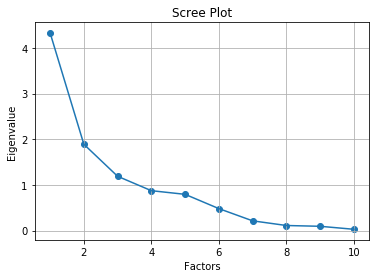

In [40]:
factor_number_tester = FactorAnalyzer(n_factors=10, rotation=None) # Using number of factors = number of columns
factor_number_tester.fit(wellness_df) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,wellness_df.shape[1]+1),ev)
plt.plot(range(1,wellness_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


It seems like the elbow forms at the second factor so I will use 2 factors for my analysis.

### Perform Factor Analysis

In [41]:
list(wellness_df.columns)

['Fatigue',
 'Soreness',
 'Desire',
 'Irritability',
 'SleepHours',
 'SleepQuality',
 'Pain',
 'Illness',
 'Menstruation',
 'TrainingReadiness']

In [51]:
fa = FactorAnalyzer(n_factors=2, rotation=None) # No need to perform roation when we are using 1 factor.

fa.fit(wellness_df)
fa.loadings_


array([[ 0.98819316,  0.16931777],
       [ 0.83107281,  0.14883669],
       [ 0.74405409,  0.12848052],
       [ 0.86349711,  0.29161545],
       [ 0.29146753, -0.30820807],
       [ 0.86776486, -0.07258102],
       [-0.28936928,  0.8116972 ],
       [-0.29032554,  0.79903454],
       [-0.33196391,  0.03267786],
       [ 0.05762742, -0.13698691]])

The rule of thumb for seeing if a observation is related to a factor is a loading of `0.7` or higher.

From this we see that `Fatigue`, `Soreness`, `Desire`, `Irritability`, and `SleepQuality` all relate to the first factor. This is interesting because these are the observations that made up the Monitor Score. We can see this as subjective wellness as they are all self reported values.

The second is related to Pain and Illness. We can see this as objective wellness.

In [54]:
fa.get_factor_variance()

(array([4.08596509, 1.56976969]),
 array([0.40859651, 0.15697697]),
 array([0.40859651, 0.56557348]))

This 2 factor model explains `56.5%` of the variance which is adequate.

#### Try 3 Factors

Some would say that the elbow of the scree plot occurs at the 3rd factor. Just to make sure I should not be using 3 factors, let's see what happens when I do.

In [56]:
fa_alt = FactorAnalyzer(n_factors=3, rotation=None) # No need to perform roation when we are using 1 factor.

fa_alt.fit(wellness_df)
fa_alt.loadings_


array([[ 0.9854301 ,  0.16318655,  0.07269749],
       [ 0.83554686,  0.15397207, -0.16496417],
       [ 0.76144494,  0.12313429,  0.28273016],
       [ 0.86743132,  0.29785842, -0.15366649],
       [ 0.29011531, -0.30631069, -0.07210185],
       [ 0.86419853, -0.07368991, -0.0700473 ],
       [-0.28570162,  0.8011951 ,  0.05580599],
       [-0.28988217,  0.8052059 ,  0.12205718],
       [-0.33494931,  0.04047325, -0.2147813 ],
       [ 0.06579117, -0.20016873,  0.68468932]])

The third factor is barely related to Training Readiness however, Training Readiness was not very appropriate for use in Factor Analysis based on the KMO test. Given that the third factor is only realted to a column that should not nessesarily be used in factor analysis, the third factor does not add much value and can therefore be ignored.

## Conclusions

Given the wellness data, we can summarize it into summary measures by taking the `Monitor Score` with the categorical variables `Pain` and `Illness`. This gives us as nice 3 feature description of ones wellness. Since the `Monitor Score` is on a different scale than `Pain` and `Illness`, we can standardize the `Monitor Score`.

## Next Steps

I can also hold the player id and date series back as variables before dropping them and re-attach them to the data frame so it can be linked to performance and training load data.

## What I Am Still Confused About

How does rotation come into play with factor analysis?

How should I deal with the nutrition column. It has a lot of missing values. Should I ignore it altogether? I ignored it for now.